In [1]:
import numpy as np

import pandas as pd

from tqdm import tqdm

import seaborn as sns

from joblib import dump#, load

import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler#, StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential#, load_model
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

Definindo o tema do seaborn:

In [2]:
sns.set_theme()

Definição da SEED:

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED) # Numpy

# Carregando os dados

Os valores são números muito pequenos com muitas casas decimais, por isso é bom que o dataframe consiga representar isso também.

In [4]:
pd.set_option('display.float_format', '{:.20f}'.format)

Carregando os dados:

In [5]:
df_benign = pd.read_csv("data\Dados Benignos\Dados Benignos 2024_6_26-18h_06m_17s\Dados Benignos.csv")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\henri\AppData\Local\Temp\ipykernel_104404\519012802.py:1: SyntaxWarning: invalid escape sequence '\D'
  df_benign = pd.read_csv("data\Dados Benignos\Dados Benignos 2024_6_26-18h_06m_17s\Dados Benignos.csv")


In [6]:
df_drop_packets = pd.read_csv("data\Ataques\Drop Packets 2024_7_1-18h_57m_17s\Drop Packets.csv")
df_delay = pd.read_csv("data\Ataques\Delay 2024_7_1-19h_02m_29s\Delay.csv")
df_out_of_sequence = pd.read_csv("data\Ataques\Out of Sequence 2024_7_1-19h_07m_28s\Out of Sequence.csv")
df_transmit_timestamp_jitter = pd.read_csv("data\Ataques\Transmit Timestamp Jitter 2024_6_26-18h_53m_22s\Transmit Timestamp Jitter.csv")

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\henri\AppData\Local\Temp\ipykernel_104404\604311421.py:1: SyntaxWarning: invalid escape sequence '\A'
  df_drop_packets = pd.read_csv("data\Ataques\Drop Packets 2024_7_1-18h_57m_17s\Drop Packets.csv")
C:\Users\henri\AppData\Local\Temp\ipykernel_104404\604311421.py:2: SyntaxWarning: invalid escape sequence '\A'
  df_delay = pd.read_csv("data\Ataques\Delay 2024_7_1-19h_02m_29s\Delay.csv")
C:\Users\henri\AppData\Local\Temp\ipykernel_104404\604311421.py:3: SyntaxWarning: invalid escape sequence '\A'
  df_out_of_sequence = pd.read_csv("data\Ataques\Out of Sequence 2024_7_1-19h_07m_28s\Out 

In [7]:
df_benign

,Rel Time,Length,Data_1,Data_2,Data_3,Data_4,Data_5,Data_6,Data_7,Data_8,...,Data_44,Data_45,Data_46,Data_47,Data_48,Data_49,Data_50,Data_51,Data_52,Data_53
0,0.00000000000000000000,170,37159,37159,36947,35264,36740,33886,36538,33050,...,19947,33675,23169,33577,25995,33486,28377,33399,30272,33318
1,0.00066600000000000003,170,32949,28377,32907,25995,32871,23169,32840,19947,...,33050,33318,33886,33399,35264,33486,37159,33577,39541,33675
2,0.00066699999999999995,170,34373,0,34508,4276,34649,8480,34795,12539,...,12539,38532,8480,38778,4276,39027,0,39282,61260,39541
3,0.00066699999999999995,170,41186,37159,41475,35264,41768,33886,42065,33050,...,19947,48416,23169,48783,25995,49153,28377,49526,30272,49901
4,0.00066600000000000003,170,52209,28377,52602,25995,52997,23169,53394,19947,...,33050,61260,33886,61685,35264,62111,37159,62538,39541,62966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899836,0.00066600000000000003,170,32949,28377,32907,25995,32871,23169,32840,19947,...,33050,33318,33886,33399,35264,33486,37159,33577,39541,33675
899837,0.00066699999999999995,170,34373,0,34508,4276,34649,8480,34795,12539,...,12539,38532,8480,38778,4276,39027,0,39282,61260,39541
899838,0.00066699999999999995,170,41186,37159,41475,35264,41768,33886,42065,33050,...,19947,48416,23169,48783,25995,49153,28377,49526,30272,49901
899839,0.00066699999999999995,170,52209,28377,52602,25995,52997,23169,53394,19947,...,33050,61260,33886,61685,35264,62111,37159,62538,39541,62966


In [8]:
df_benign = df_benign[[df_benign.columns[0]]]
df_drop_packets = df_drop_packets[[df_drop_packets.columns[0]]]
df_delay = df_delay[[df_delay.columns[0]]]
df_out_of_sequence = df_out_of_sequence[[df_out_of_sequence.columns[0]]]
df_transmit_timestamp_jitter = df_transmit_timestamp_jitter[[df_transmit_timestamp_jitter.columns[0]]] 

In [9]:
df_benign

,Rel Time
0,0.00000000000000000000
1,0.00066600000000000003
2,0.00066699999999999995
3,0.00066699999999999995
4,0.00066600000000000003
...,...
899836,0.00066600000000000003
899837,0.00066699999999999995
899838,0.00066699999999999995
899839,0.00066699999999999995


In [10]:
df_drop_packets

,Rel Time
0,0.00000000000000000000
1,0.00066600000000000003
2,0.00066699999999999995
3,0.00066699999999999995
4,0.00066600000000000003
...,...
183184,0.00133299999999999998
183185,0.00133399999999999990
183186,0.00133299999999999998
183187,0.00133299999999999998


In [11]:
#ocorrencias = (df_drop_packets['Rel Time'] > 0.000668).sum()

#print(ocorrencias)

#indices = df_drop_packets.index[df_drop_packets['Rel Time'] > 0.000668].tolist()

#print(indices)

#maior_diferenca = float('-inf')

# Itera pela indices, calculando a diferença entre elementos consecutivos
#for i in range(len(indices) - 1):
#    diferenca = abs(indices[i + 1] - indices[i])
#    if diferenca > maior_diferenca:
#        maior_diferenca = diferenca

# Exibe a maior diferença
#print(f"A maior diferença entre elementos consecutivos é: {maior_diferenca}")

Manipualação da quantidade/proporção dos dados:

In [12]:
# OPCIONAL!!!
len_min = min(len(df_benign),len(df_drop_packets),len(df_delay),len(df_out_of_sequence), len(df_transmit_timestamp_jitter))
NUM_OF_ATTACKS = 4

#len_min = int(len_min / 10)

df_benign = df_benign.head(len_min * NUM_OF_ATTACKS)
df_drop_packets = df_drop_packets.head(len_min)
df_delay = df_delay.head(len_min)
df_out_of_sequence = df_out_of_sequence.head(len_min)
df_transmit_timestamp_jitter = df_transmit_timestamp_jitter.head(len_min)

In [13]:
del len_min

# Tratando dados

## Normalização dos dados

Criação e uso do scaler:

In [14]:
scaler = MinMaxScaler()

scaler.fit(df_benign)

df_benign_scaled = pd.DataFrame(scaler.transform(df_benign), columns=df_benign.columns, index=df_benign.index)
df_drop_packets_scaled = pd.DataFrame(scaler.transform(df_drop_packets), columns=df_drop_packets.columns, index=df_drop_packets.index)
df_delay_scaled = pd.DataFrame(scaler.transform(df_delay), columns=df_delay.columns, index=df_delay.index)
df_out_of_sequence_scaled = pd.DataFrame(scaler.transform(df_out_of_sequence), columns=df_out_of_sequence.columns, index=df_out_of_sequence.index)
df_transmit_timestamp_jitter_scaled = pd.DataFrame(scaler.transform(df_transmit_timestamp_jitter), columns=df_transmit_timestamp_jitter.columns, index=df_transmit_timestamp_jitter.index)

In [15]:
del df_benign
del df_drop_packets
del df_delay
del df_out_of_sequence
del df_transmit_timestamp_jitter

In [16]:
df_benign_scaled

,Rel Time
0,0.00000000000000000000
1,0.99850074962518764465
2,1.00000000000000000000
3,1.00000000000000000000
4,0.99850074962518764465
...,...
732751,0.99850074962518764465
732752,1.00000000000000000000
732753,1.00000000000000000000
732754,0.99850074962518764465


## Criação de Labels

In [17]:
list_labels_benign = [1] * len(df_benign_scaled)
list_labels_drop_packets = [-1] * len(df_drop_packets_scaled)
list_labels_delay = [-1] * len(df_delay_scaled)
list_labels_out_of_sequence = [-1] * len(df_out_of_sequence_scaled)
list_labels_transmit_timestamp_jitter = [-1] * len(df_transmit_timestamp_jitter_scaled)

classifier_type = "bc"

## Criação de Janelas Temporais

### Criação de Janelas Deslizantes

Criação da função de divisão dos dados em janelas:

In [18]:
def create_slicing_windows(data, labels, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(labels[i + time_step])
    return np.array(X), np.array(Y)

Definição do tamanho da janela:

In [19]:
WINDOW_SIZE = 100

Criação das janelas deslizantes:

In [20]:
benign_windows, benign_labels = create_slicing_windows(df_benign_scaled, list_labels_benign, WINDOW_SIZE)
del df_benign_scaled, list_labels_benign

drop_packets_windows, drop_packets_labels = create_slicing_windows(df_drop_packets_scaled, list_labels_drop_packets, WINDOW_SIZE)
del df_drop_packets_scaled, list_labels_drop_packets

delay_windows, delay_labels = create_slicing_windows(df_delay_scaled, list_labels_delay, WINDOW_SIZE)
del df_delay_scaled, list_labels_delay

out_of_sequence_windows, out_of_sequence_labels = create_slicing_windows(df_out_of_sequence_scaled, list_labels_out_of_sequence, WINDOW_SIZE)
del df_out_of_sequence_scaled, list_labels_out_of_sequence

transmit_timestamp_jitter_windows, transmit_timestamp_jitter_labels = create_slicing_windows(df_transmit_timestamp_jitter_scaled, list_labels_transmit_timestamp_jitter, WINDOW_SIZE)
del df_transmit_timestamp_jitter_scaled, list_labels_transmit_timestamp_jitter

In [21]:
len(benign_windows), len(benign_windows[0])

(732656, 100)

In [22]:
benign_windows

array([[[0.        ],
        [0.99850075],
        [1.        ],
        ...,
        [0.99850075],
        [1.        ],
        [1.        ]],

       [[0.99850075],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [0.99850075]],

       [[1.        ],
        [1.        ],
        [0.99850075],
        ...,
        [1.        ],
        [0.99850075],
        [1.        ]],

       ...,

       [[1.        ],
        [1.        ],
        [0.99850075],
        ...,
        [1.        ],
        [0.99850075],
        [1.        ]],

       [[1.        ],
        [0.99850075],
        [1.        ],
        ...,
        [0.99850075],
        [1.        ],
        [1.        ]],

       [[0.99850075],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [0.99850075]]])

## Dividindo dados em Treino, Validação e Teste

Quantidade de dados benignos dividido pelo total:

In [23]:
#len(benign_windows) / (len(benign_windows) + len(malicious_random_dos_windows) + len(malicious_spoofing_zero_payload_windows) + len(malicious_zero_dos_windows))

Concatenação das janelas, em ordem:

In [24]:
data = np.vstack((benign_windows, drop_packets_windows, delay_windows, out_of_sequence_windows, transmit_timestamp_jitter_windows))

In [25]:
data_malicious = np.vstack((drop_packets_windows, delay_windows, out_of_sequence_windows, transmit_timestamp_jitter_windows))

In [26]:
data_labels = np.hstack((benign_labels, drop_packets_labels, delay_labels, out_of_sequence_labels, transmit_timestamp_jitter_labels))

In [27]:
data_malicious_labels = np.hstack((drop_packets_labels, delay_labels, out_of_sequence_labels, transmit_timestamp_jitter_labels))

In [28]:
del drop_packets_windows
del drop_packets_labels
del delay_windows
del delay_labels
del out_of_sequence_windows
del out_of_sequence_labels
del transmit_timestamp_jitter_windows
del transmit_timestamp_jitter_labels
del benign_labels

### Divisão em treino, validação e teste.

#### Abordagem supervisionada:

In [29]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data, data_labels, test_size=0.25, random_state=RANDOM_SEED)

In [30]:
val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, test_size=0.5, random_state=RANDOM_SEED)

In [31]:
del data, data_labels
del val_test_data, val_test_labels

#### Abordagem não-supervisionada:

In [32]:
train_data_2 = benign_windows[:int((len(benign_windows) // 1.05))]

In [33]:
test_data_2 = np.vstack((data_malicious, benign_windows[int((len(benign_windows) // 1.05)):]))

In [34]:
malicious_proportion = len(data_malicious) / (len(data_malicious) + len(benign_windows[int((len(benign_windows) // 1.05)):]))
malicious_proportion

0.9545269112213178

In [35]:
benign_labels = [1] * int(len(benign_windows) - (len(benign_windows) // 1.05))

test_data_2_labels = np.hstack((data_malicious_labels, benign_labels))

In [36]:
del data_malicious
del benign_windows
del benign_labels
del data_malicious_labels

### Shape dos dados de treino:

In [37]:
train_data.shape

(1098759, 100, 1)

In [38]:
train_data_2.shape

(697767, 100, 1)

# IAs

## LSTM (supervisionado)

### Treinamento do modelo

Variável que define se é supervisionado ou não-supervisionado:

In [39]:
s_OR_ns = "s"

Quantidade de features, para o modelo lidar com as entradas:

In [40]:
FEATURES_COUNT = train_data.shape[2] # Número de features dos dados

Construção do modelo LSTM:

In [41]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES_COUNT)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, kernel_regularizer=l2(0.0000001)))

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')
#model.compile(optimizer="adam", loss='mse')

c:\Users\henri\OneDrive\Área de Trabalho\Programação\Projetos e Atividades\Graduação BSI\PETs\IDS para redes veiculares\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Definição da paciência:

In [42]:
PATIENCE = 4

Configuração do early stop:

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

Definição da quantidade de épocas e o tamanho do Batch:

In [44]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

**TREINAMENTO DO MODELO:**

In [45]:
# Treinando o modelo
history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels), callbacks=[early_stopping])

Epoch 1/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 446s 13ms/step - loss: 0.2319 - val_loss: 0.0934
Epoch 2/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 441s 13ms/step - loss: 0.1650 - val_loss: 0.0980
Epoch 3/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 388s 11ms/step - loss: 0.1674 - val_loss: 0.0156
Epoch 4/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 381s 11ms/step - loss: 0.1073 - val_loss: 0.0160
Epoch 5/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 409s 12ms/step - loss: 0.1251 - val_loss: 0.1196
Epoch 6/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 447s 13ms/step - loss: 0.2346 - val_loss: 0.4474
Epoch 7/50
34337/34337 ━━━━━━━━━━━━━━━━━━━━ 460s 13ms/step - loss: 0.1321 - val_loss: 0.1062


In [46]:
del train_data, train_labels
del val_data, val_labels

In [47]:
# Avaliando o modelo no conjunto de teste
loss = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)

5723/5723 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.0155
Test Loss: 0.015619675628840923


In [48]:
predicts = model.predict(test_data)
predicts

5723/5723 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step


array([[-0.94935834],
       [ 1.1694362 ],
       [ 1.1703    ],
       ...,
       [-0.94714504],
       [ 1.170512  ],
       [-0.9531326 ]], dtype=float32)

In [49]:
if classifier_type == "mc":

    intervalos = [(-4, -3), (-3, -2), (-2, -1), (-1, 0), (0, 1)]

    # Função para contar os elementos em cada intervalo
    def contar_elementos(array, intervalos):
        contagem = {}
        for inicio, fim in intervalos:
            contagem[f'{inicio} a {fim}'] = np.sum((array >= inicio) & (array < fim))
        return contagem

    # Contando os elementos em cada intervalo
    contagem = contar_elementos(predicts, intervalos)

    # Imprimindo o resultado
    for intervalo, quantidade in contagem.items():
        print(f'Elementos no intervalo {intervalo}: {quantidade}')

### Avaliações

Transformando as predições em uma numpy array unidimensional:

In [50]:
predicts_1d = np.array([predict[0] for predict in predicts])
predicts_1d

array([-0.94935834,  1.1694362 ,  1.1703    , ..., -0.94714504,
        1.170512  , -0.9531326 ], dtype=float32)

In [51]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

Curva Recall:

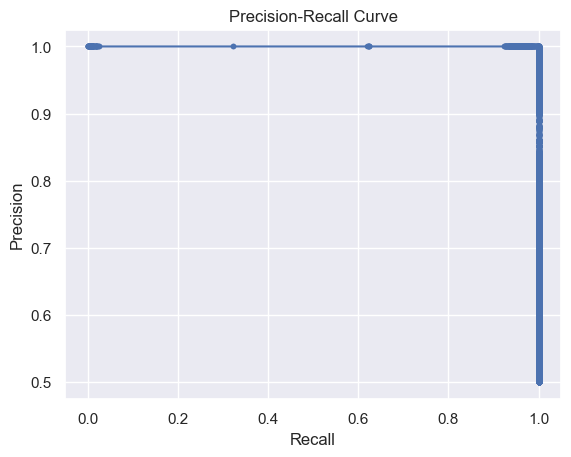

In [52]:
if classifier_type == "bc":
    plot_precision_recall_curve(test_labels, predicts_1d)

In [53]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

Curva ROC:

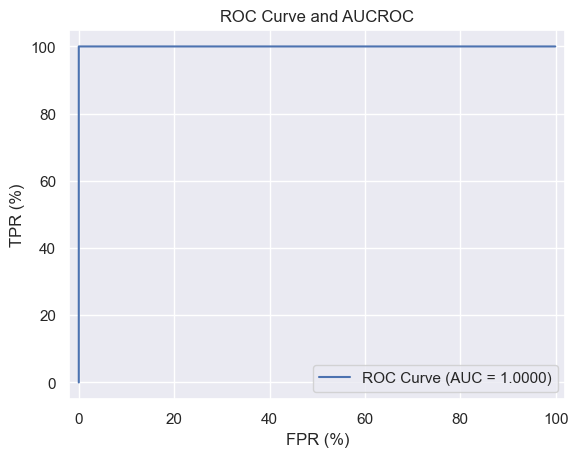

In [54]:
if classifier_type == "bc":
    plot_roc_curve(test_labels, predicts_1d)

Transformando todos os valores de predições acima de 0 em 1, enquanto os outros recebem a função round(), ou seja, serão arredondados pro número inteiro mais próximo. Após isso, os números que forem iguais a 0, serão transformados em -1. É como se todo mundo igual ou menor que 0, fosse malicioso, mas 0 não é um valor malicioso de label, é mais como se fosse um threshold, então nada deve ser igual a 0. Esse problema é minimizado em classificações binárias.

In [55]:
predicts_1d = np.where(predicts_1d > 0, 1, np.round(predicts_1d))
predicts_1d = np.where(predicts_1d == 0, -1, predicts_1d)
predicts_1d

array([-1.,  1.,  1., ..., -1.,  1., -1.], dtype=float32)

In [56]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

Matriz de Confusão:

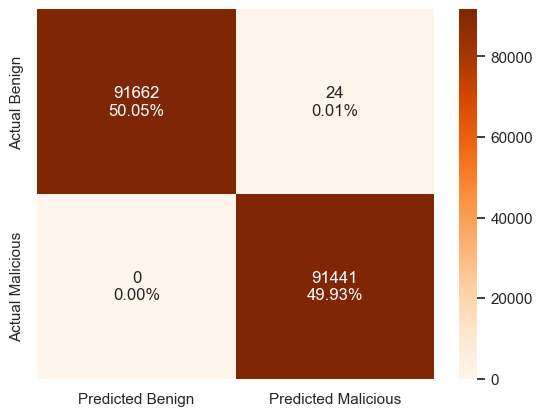

In [57]:
plot_confusion_matrix(test_labels, predicts_1d)

In [58]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

Métricas Gerais:

In [59]:
get_overall_metrics(test_labels, predicts_1d)

{'acc': 0.999868943410857,
 'tpr': 1.0,
 'fpr': 0.0002617629736273804,
 'precision': 0.9997376045481878,
 'f1-score': 0.999868785058992}

In [60]:
del test_data, test_labels

### Salvando o modelo:

Salvando modelo com diferentes bibliotecas:

In [61]:
model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.keras')

In [62]:
with open(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)

In [63]:
dump(model, f"models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.joblib")

['models/model_LSTM_s_bc_ws100.joblib']

In [64]:
dump(scaler, f"models/scalers/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}")

['models/scalers/scaler_model_LSTM_s_bc_ws100']

In [65]:
del loss
del predicts
del predicts_1d
del history

## LSTM (não-supervisionado)

### Treinamento do modelo

Definindo que é não-supervisionado(ns) e classificador binário(bc):

In [66]:
s_OR_ns = "ns"
classifier_type = "bc"

Coletando a quantidade de features:

In [67]:
FEATURES_COUNT = train_data_2.shape[2]

Construção do modelo LSTM:

In [68]:
# Construindo o modelo Autoencoder LSTM
inputs = Input(shape=(WINDOW_SIZE, FEATURES_COUNT))
encoded = LSTM(50, activation='tanh', return_sequences=False)(inputs)  # Codificador
decoded = RepeatVector(WINDOW_SIZE)(encoded)  # Decodificador
decoded = LSTM(FEATURES_COUNT, return_sequences=True)(decoded)

# Adicionando Dropout e Normalização em Batch
decoded = Dropout(0.1)(decoded)
decoded = BatchNormalization()(decoded)

# Camada de saída
outputs = Dense(FEATURES_COUNT, kernel_regularizer=l2(0.0000001))(decoded)

# Compilando o modelo
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')

Definindo a paciência:

In [69]:
PATIENCE = 4

Configurando o early stopping:

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

Definindo a quantidade de épocas e o tamanho do Batch:

In [71]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

**TREINAMENTO DO MODELO:**

In [72]:
history = model.fit(train_data_2, train_data_2, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 363s 21ms/step - loss: 0.0185 - val_loss: 7.2799e-07
Epoch 2/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 383s 22ms/step - loss: 8.5188e-07 - val_loss: 7.5991e-07
Epoch 3/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 377s 22ms/step - loss: 7.9974e-07 - val_loss: 9.0079e-07
Epoch 4/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 357s 20ms/step - loss: 8.0294e-07 - val_loss: 6.8200e-07
Epoch 5/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 340s 19ms/step - loss: 7.8373e-07 - val_loss: 6.4999e-07
Epoch 6/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 336s 19ms/step - loss: 7.3292e-07 - val_loss: 1.2642e-06
Epoch 7/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 341s 20ms/step - loss: 7.0700e-07 - val_loss: 6.1691e-07
Epoch 8/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 344s 20ms/step - loss: 7.0775e-07 - val_loss: 6.0632e-07
Epoch 9/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 347s 20ms/step - loss: 6.8892e-07 - val_loss: 5.9439e-07
Epoch 10/50
17445/17445 ━━━━━━━━━━━━━━━━━━━━ 349s 20ms/step - loss: 7.2004e-07 - val_loss: 6.32

KeyboardInterrupt: 

In [ ]:
del train_data_2

### Predições e Classificações

In [73]:
predicts = model.predict(test_data_2)
predicts

23977/23977 ━━━━━━━━━━━━━━━━━━━━ 198s 8ms/step


array([[[0.999601  ],
        [0.9996009 ],
        [0.9996009 ],
        ...,
        [0.9996009 ],
        [0.9996009 ],
        [0.9996009 ]],

       [[0.99960107],
        [0.99960095],
        [0.9996009 ],
        ...,
        [0.9996009 ],
        [0.9996009 ],
        [0.9996009 ]],

       [[0.99960107],
        [0.99960095],
        [0.99960095],
        ...,
        [0.99960095],
        [0.99960095],
        [0.99960095]],

       ...,

       [[0.99960107],
        [0.99960095],
        [0.99960095],
        ...,
        [0.99960095],
        [0.99960095],
        [0.99960095]],

       [[0.99960107],
        [0.99960095],
        [0.99960095],
        ...,
        [0.99960095],
        [0.99960095],
        [0.99960095]],

       [[0.99960107],
        [0.99960095],
        [0.99960095],
        ...,
        [0.9996009 ],
        [0.9996009 ],
        [0.9996009 ]]], dtype=float32)

In [74]:
def mean_square_error(original_data, predicted_data, threshold=0.5):
    """
    Função para classificar as amostras como benignas (1) ou malignas (-1) com base no erro de reconstrução.

    Parâmetros:
        original_data (numpy.array): Os dados originais.
        predicted_data (numpy.array): As previsões geradas pelo modelo autoencoder.
        threshold (float): O limiar de decisão para classificar as amostras.

    Retorna:
        numpy.array: Um array de classificação binária para cada amostra.
    """
    # Calcula o erro de reconstrução (MSE) para cada amostra
    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    # Classifica as amostras com base no limiar
    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    #del reconstruction_errors

    return classifications, reconstruction_errors

In [75]:
def mean_absolute_error(original_data, reconstructed_data, threshold=0.5):
    
    """
    Calcula o Erro Absoluto Médio (MAE) entre os dados originais e reconstruídos.

    Args:
    - original_data: array NumPy contendo os dados originais.
    - reconstructed_data: array NumPy contendo os dados reconstruídos pelo modelo.

    Returns:
    - mae: o Erro Absoluto Médio entre os dados originais e reconstruídos.
    """


    # Calcula a diferença absoluta entre os dados originais e reconstruídos
    # Calcula o MAE como a média da diferença absoluta
    mae = np.mean((np.abs(original_data - reconstructed_data)), axis=(1, 2))

    classifications = np.where(mae < threshold, 1, -1)

    del mae

    return classifications

In [76]:
def find_best_threshold_mse(original_data, predicted_data, proportion, threshold=0.5):

    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    del reconstruction_errors

    proportion_predicted = len(classifications[classifications == -1]) / len(classifications)

    del classifications

    print(f"Threshold: {threshold}, Proportion_predicted: {proportion_predicted}")

    if proportion_predicted < proportion:
        del proportion_predicted
        return find_best_threshold_mse(original_data, predicted_data, proportion, 0.9*threshold)
    elif proportion_predicted > proportion:
        del proportion_predicted
        return find_best_threshold_mse(original_data, predicted_data, proportion, 1.1*threshold)
    else:
        del proportion_predicted
        return threshold

In [77]:
def find_best_threshold(y_true, y_scores):
    """
    Encontra o melhor threshold baseado na proporção correta entre dados malignos e benignos.

    Parameters:
    y_true (np.array): Array de valores verdadeiros (-1 para benigno, 1 para maligno)
    y_scores (np.array): Array de scores preditos pelo modelo

    Returns:
    float: Melhor threshold encontrado
    """
    
    # Certificar que os inputs são arrays numpy
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Ordenar os scores e calcular possíveis thresholds
    thresholds = np.sort(y_scores)
    
    # Inicializar variáveis para acompanhar o melhor threshold e melhor acurácia ponderada
    best_threshold = None
    best_weighted_accuracy = -np.inf
    
    # Calcular proporção dos dados malignos e benignos
    prop_malignos = np.sum(y_true == 1) / len(y_true)
    prop_benignos = np.sum(y_true == -1) / len(y_true)
    
    for threshold in tqdm(thresholds):
        # Calcular predições baseadas no threshold atual
        y_pred = np.where(y_scores >= threshold, 1, -1)
        
        # Calcular acurácia ponderada
        accuracy_malignos = np.sum((y_true == 1) & (y_pred > 0)) / np.sum(y_true == 1)
        accuracy_benignos = np.sum((y_true == -1) & (y_pred == 0)) / np.sum(y_true == -1)
        
        weighted_accuracy = prop_malignos * accuracy_malignos + prop_benignos * accuracy_benignos
        
        # Atualizar melhor threshold se a acurácia ponderada atual for melhor
        if weighted_accuracy > best_weighted_accuracy:
            best_weighted_accuracy = weighted_accuracy
            best_threshold = threshold
    
    return best_threshold

Registrando os erros de reconstrução:

In [78]:
classifications_mse, reconstruction_errors = mean_square_error(test_data_2, predicts)

Encontrando um bom Threshold:

In [ ]:
THRESHOLD = find_best_threshold_mse(test_data_2_labels, reconstruction_errors, malicious_proportion)

In [80]:
reconstruction_errors

array([8.00484336e-02, 7.00564134e-02, 7.00563946e-02, ...,
       5.06135346e-07, 5.06135346e-07, 5.16637995e-07])

In [110]:
THRESHOLD

Classificando de acordo com o Threshold encontrado:

In [111]:
classifications_mse, reconstruction_errors = mean_square_error(test_data_2, predicts, THRESHOLD)

### Avaliações

In [112]:
len(classifications_mse[classifications_mse == -1]) / len(classifications_mse), malicious_proportion

(0.9545269112213178, 0.9545269112213178)

In [113]:
reconstruction_errors_rounded = np.where(reconstruction_errors > THRESHOLD, -1, 1)
reconstruction_errors_rounded

array([-1, -1, -1, ...,  1,  1,  1])

In [114]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

Curva ROC:

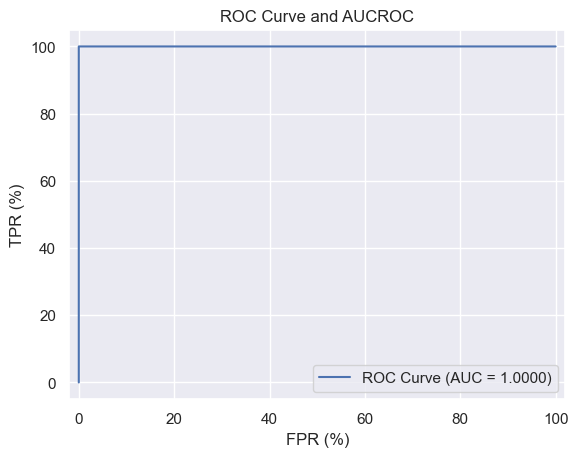

In [115]:
plot_roc_curve(test_data_2_labels, 1/reconstruction_errors)

In [116]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

Curva Recall:

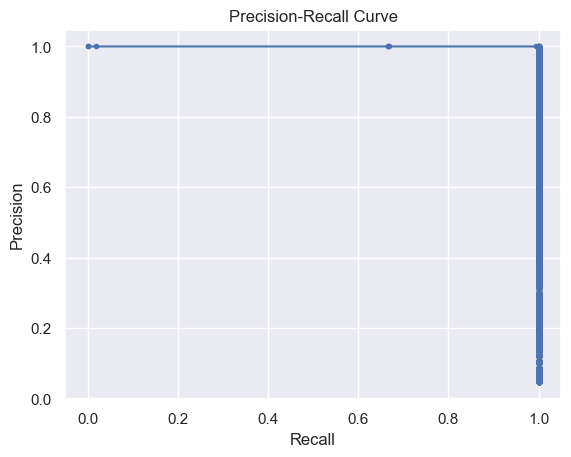

In [117]:
plot_precision_recall_curve(test_data_2_labels, 1/reconstruction_errors)

In [118]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

Matriz de Confusão:

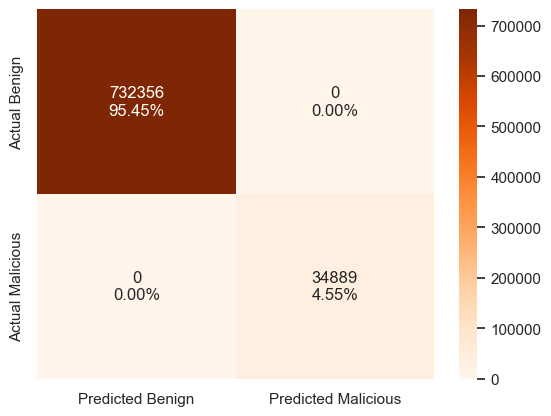

In [119]:
plot_confusion_matrix(test_data_2_labels, reconstruction_errors_rounded)

In [120]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

Métricas Gerais:

In [121]:
get_overall_metrics(test_data_2_labels, reconstruction_errors_rounded)

{'acc': 1.0, 'tpr': 1.0, 'fpr': 0.0, 'precision': 1.0, 'f1-score': 1.0}

### Salvando o modelo:

Salvando modelo com diferentes bibliotecas:

In [122]:
THRESHOLD = str(THRESHOLD).replace(".",",")

In [123]:
model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.keras')

In [124]:
with open(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)

In [125]:
dump(model, f"models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.joblib")

['models/model_LSTM_ns_bc_ws100_t1e-06.joblib']

In [126]:
dump(scaler, f"models/scalers/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}")

['models/scalers/scaler_model_LSTM_ns_bc_ws100_t1e-06']